<a href="https://colab.research.google.com/github/neelmehta00/Seattle/blob/master/Seattle_Official_Real_Estate_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Importing models, functions to be used

In [ ]:
monthly_avg = [493.2, 499.1, 503, 507.9, 511.9, 521.9, 521.9, 527.6, 536.1, 551.7, 558.4, 564.4, 565.4, 574.3, 581.8, 581.8, 591.3, 597.7, 604.5, 611.1, 615.9, 621, 632.4, 640.7, 640.7, 649.4, 655.1, 659, 665.5, 676.2, 700.4, 709.6, 717.5, 717.5, 733.9, 741.9, 749.8, 762.9, 775.1, 775.1, 783.5, 786.8, 783.7, 781.2, 781.1, 781.1, 780.8, 777.5, 770.6, 757.1, 757.1, 751.6, 746.5, 741.4, 741.4, 742.1, 744.2, 744.2, 744.3, 747.5, 752.7, 758.3, 762.9, 767.9, 762.7, 758.4, 755.6, 752.3, 751.7, 751.8, 752.2, 752.2]
print(len(monthly_avg))

72


In [ ]:
import pandas as pd
import math
import random
import scipy.stats as stats
import numpy as np
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
R = 6373.0

#This is a function for distance(km) between two points given their lat and longs. 
def LatLongDist(lat1, long1, lat2, long2):
  A = math.radians(lat1)
  B = math.radians(long1)
  C = math.radians(lat2)
  D = math.radians(long2)
  dlon = D - B
  dlat = C - A
  a = math.sin(dlat / 2)**2 + math.cos(A) * math.cos(C) * math.sin(dlon / 2)**2
  c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
  return R * c

#Below is non-Traditional scoring function. 

def score_from_distances(house_to_stores, d1,d2,d3,d4,d5):
  count1 = 0
  count2 = 0
  count3 = 0
  count5 = 0 
  count7 = 0
  score = 10
  for dist in house_to_stores:
    if dist <= d1:
      count1 += 1
    if dist <= d2:
      count2 += 1
    if dist <= d3:
      count3 += 1
    if dist <= d4:
      count5 += 1
    if dist <= d5:
      count7 += 1
  if count1 >= 2:
    pass
  elif count1 >= 1:
    score -= 1
  elif count2 >= 2:
    score -= 2
  elif count2 >= 1:
    score -= 3
  elif count3 >= 2:
    score -= 4
  elif count3 >= 1:
    score -= 5
  elif count5 >= 2:
    score -= 6
  elif count5 >= 1:
    score -= 7
  elif count7 >= 2:
    score -= 8
  elif count7 >= 1:
    score -= 9
  else: score = 0
  return score

#Below is the atypical scoring function for inferior stores (fastfood)
def score_from_inferiors(house_to_stores, d1,d2,d3,d4,d5):
  count1 = 0
  count2 = 0
  count3 = 0
  count4 = 0 
  count5 = 0
  score = 10
  for dist in house_to_stores:
    if dist > d5:
      count1 += 1
    if dist >= d4:
      count2 += 1
    if dist >= d3:
      count3 += 1
    if dist >= d2:
      count4 += 1
    if dist >= d1:
      count5 += 1
  if count1 == 1:
    pass
  elif count1 >= 2:
    score -= 1
  elif count2 == 1:
    score -= 2
  elif count2 >= 2:
    score -= 3
  elif count3 == 1:
    score -= 4
  elif count3 >= 2:
    score -= 5
  elif count4 == 1:
    score -= 6
  elif count4 >= 2:
    score -= 7
  elif count5 == 1:
    score -= 8
  elif count5 >= 2:
    score -= 9
  else: score = 0
  return score

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# 2. Preprocessing Houses(1/3)



In [ ]:
house_df = pd.read_csv('https://raw.githubusercontent.com/neelmehta00/Seattle/master/Seattle%20-%20NewZest.csv')
print(len(house_df))
address = house_df["Address"]
price = house_df["Price"]
link = house_df["link"]
link1 = house_df["link1"]
listdrop1 = []


#FIRST, getting rid of duplicate houses
for i in range(len(house_df)): 
  for j in range(len(house_df)):
    if i != j:
      if address.iloc[i] == address.iloc[j] and price.iloc[i] == price.iloc[j]:
        listdrop1.append(i)


#SECOND, house from 1before 2015, 2useless zestimates, 3price is nan
for i in range(len(house_df)):
    if not(house_df['price2'].iloc[i] > 0 and (int(house_df['date2'].iloc[i][-4:]) >= 2015)): # from before 2015
      listdrop1.append(i)
    if house_df['ZestYear 2015'].iloc[i] == "Today" or house_df['ZestYear 2015'].iloc[i] == "Listed for": # useless zestimates
      listdrop1.append(i)
    if math.isnan(house_df['ZestPrice 2020'].iloc[i]) or math.isnan(house_df['ZestPrice 2015'].iloc[i]): #nan
      listdrop1.append(i)

      
dictOfYear = {}
listdrop2 = []
for i in range(len(listdrop1)):
  year = listdrop1[i]
  dictOfYear[year] = listdrop1[i]
for key in dictOfYear:
  listdrop2.append(key)


for item in listdrop2:
  house_df.drop([item], axis=0, inplace=True)
print(len(house_df))

202
150


In [ ]:
house_df.columns

Index(['link', 'Address', 'Latitude', 'Longitude', 'Price', '#Bed', '#Bath',
       'Square Foot', 'Year Built', 'date1', 'price1', 'date2', 'price2',
       'date3', 'price3', 'date4', 'price4', 'date5', 'price5', 'date6',
       'price6', 'date7', 'price7', 'absolute', 'link1', 'ZestYear 2015',
       'ZestPrice 2015', 'ZestYear 2020', 'ZestPrice 2020'],
      dtype='object')

# Preprocessing Houses (2/3)

In [ ]:
#THIRD, get final_date, final_price, index_list, initial_date, initial_price, and monthly_change

index_list = []
final_date = []
final_price = []
absolute_list = []
lat_list = []
long_list = []
count = 0
for index, row in house_df.iterrows():
  index_list.append(index)
  #COME BACK TO THIS!!!!!!!!! (need to account for 2 digit months)
  
  
  if (int(row["date1"][0])) < 5:
    final_date.append(row['date1'])
    final_price.append(row['price1'])
  else:
    if int(row['price1']) < int(row['price2']) and int(row['date2'][-4:]) == 2020 and ((int(row["date1"][0])) - (int(row["date2"][0])) < 6):
      count = count + 1
      final_date.append(row['date2'])
      final_price.append(row['price2'])
    else:
      final_date.append(row['date1'])
      final_price.append(row['price1'])

  absolute_list.append(row['absolute'])
  lat_list.append(row['Latitude'])
  long_list.append(row['Longitude'])
print("# houses affected by corona: ", count)

initial_date = []
initial_price = []
count = 0
for index, row in house_df.iterrows():
  count = count + 1
  if (row['price7'] > 0) and (int(row['date7'][-4:]) >= 2015):
    initial_date.append(row['date7'])
    initial_price.append(row['price7'])
  elif (row['price6'] > 0) and (int(row['date6'][-4:]) >= 2015):
    initial_date.append(row['date6'])
    initial_price.append(row['price6'])
  elif (row['price5'] > 0) and (int(row['date5'][-4:]) >= 2015):
    initial_date.append(row['date5'])
    initial_price.append(row['price5'])
  elif (row['price4'] > 0) and (int(row['date4'][-4:]) >= 2015):
    initial_date.append(row['date4'])
    initial_price.append(row['price4'])
  elif (row['price3'] > 0) and (int(row['date3'][-4:]) >= 2015):
    initial_date.append(row['date3'])
    initial_price.append(row['price3'])
  else:
    initial_date.append(row['date2'])
    initial_price.append(row['price2'])


print("house count after first processing: %d"%len(initial_price))
print("")

#getting rid of same year/month
year_one = house_df["ZestPrice 2015"]
year2015 = []
for i in range(len(year_one)):
  year2015.append(year_one.iloc[i])


year_six = house_df['ZestPrice 2020']
year2020 = []
for i in range(len(year_six)):
  year2020.append(year_six.iloc[i])

index_list2 = []
for i in range(len(initial_date)):
  if initial_date[i][-4:] == final_date[i][-4:] and initial_date[i][:2] == final_date[i][:2]:
    index_list2.append(i)

to_subtract = 0

while len(index_list2) > 0:
  ind = index_list2.pop(0) - to_subtract
  del initial_date[ind]
  del initial_price[ind]
  del final_date[ind]
  del final_price[ind]
  del absolute_list[ind]
  del lat_list[ind]
  del long_list[ind]
  del year2015[ind]
  del year2020[ind]

  to_subtract += 1

print("house count after getting rid of same year/month: %d"%len(final_price))
print("")

#getting monthly change list, the target

#mount pleasant average prices
monthly_change = []
for i in range(len(initial_date)):
  try:
    initial = (int(initial_date[i][-4:]) - 2015) * 12 + int(initial_date[i][:2])
  except:
    initial = (int(initial_date[i][-4:]) - 2015) * 12 + int(initial_date[i][:1])

  try:
    final = (int(final_date[i][-4:]) - 2015) * 12 + int(final_date[i][:2])
  except:
    final = (int(final_date[i][-4:]) - 2015) * 12 + int(final_date[i][:1])
  num_month = final - initial
  MP_avg = (((monthly_avg[final]/monthly_avg[initial])**(1/(num_month))) - 1) * 100
  house_avg = (((final_price[i]/initial_price[i])**(1/num_month) - 1) * 100)
  monthly_change.append(house_avg - MP_avg)

print("monthly_change: ", monthly_change)
print("monthly change length: %d" %len(monthly_change))
data = {'house_absolute': absolute_list,
        'initial date': initial_date,
        'initial price': initial_price,
        'final date': final_date,
        'final price': final_price,
        'monthly change': monthly_change,
        'latitude' : lat_list,
        'longitude' : long_list,
        'year2015': year2015,
        'year2020':year2020
        }
house_df2 = pd.DataFrame(data, columns = ['house_absolute', 'initial date', 'initial price', 'final date', 'final price', 'monthly change', 'latitude', 'longitude',  'year2015', 'year2020'])

# houses affected by corona:  77
house count after first processing: 150

house count after getting rid of same year/month: 134

monthly_change:  [2.7406869308131965, -1.4326330874195103, -0.17674234511142473, 3.9010022645378895, 3.0499948960831413, -0.4591997763676803, 0.6771715067065975, -0.07500828859048347, -0.1230420324351611, 0.19004550775110207, 1.046673441685253, 1.0577972328297047, -3.1021447231393107, 4.424802067262434, -0.5930454971600385, -0.24737294104122398, 1.8005400919069325, 2.3643509193595924, -1.731252529739169, -1.7359319350769953, 1.8648079585168897, 4.255157786813335, -0.11365244240143513, -0.8378008147764238, -0.006117906785574334, -0.12931039456522964, 8.508673491623519, 0.14014404157629556, 27.297079276723213, 0.5103657134640782, 24.47865961081458, 10.714493929444746, -0.3321457358259394, 0.6787486903041318, 0.3515199697442961, 1.3934855002020852, -2.094393947339268, -0.6777133231913091, 142.64608363366884, -1.1933309551554694, 14.448848519154424, 24.3668057446

# Preprocessing Houses (3/3)

In [ ]:
#THIS IS FOR STATISTICALLY DEFINED OUTLEIRS, BUT THAT LEADS TO TOO MANY OF THEM

monthly_change2 = monthly_change
monthly_change2.sort()
Q1 = monthly_change2[25]
Q3 = monthly_change2[74]
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR
lower_bound = Q1 - 1.5 * IQR

listdrop2 = []
for index, row in house_df2.iterrows():
  if row['monthly change'] > upper_bound or row['monthly change'] < lower_bound:
    listdrop2.append(index)
print("upper: %f"%upper_bound)
print("lower: %f"%lower_bound)

print("number of statistical outliers in terms of monthly change: %d"%len(listdrop2))


for item in listdrop2:
  house_df2.drop([item], axis=0, inplace=True)

print("house count after getting rid of outliers: %d" % len(house_df2))

upper: 1.377019
lower: -1.357644
number of statistical outliers in terms of monthly change: 53
house count after getting rid of outliers: 81


# 3. Preparing Atypical data and scores for houses



In [ ]:
grocery_df = pd.read_csv("https://raw.githubusercontent.com/neelmehta00/Seattle/master/Seattle%20-%20grocery.csv")
coffeeshop_df = pd.read_csv('https://raw.githubusercontent.com/neelmehta00/Seattle/master/Seattle%20-%20Coffee.csv')
fastfood_df = pd.read_csv('https://raw.githubusercontent.com/neelmehta00/Seattle/master/Seattle%20-%20Fastfood.csv')
parks_df = pd.read_csv('https://raw.githubusercontent.com/neelmehta00/Seattle/master/Seattle%20-%20Parks.csv')
gas_df = pd.read_csv('https://raw.githubusercontent.com/neelmehta00/Seattle/master/Seattle%20-%20gas.csv')
theater_df = pd.read_csv('https://raw.githubusercontent.com/neelmehta00/Seattle/master/Seattle%20-%20Theater.csv')
wholefoods_df = pd.read_csv("https://raw.githubusercontent.com/neelmehta00/Seattle/master/Seattle%20-%20wholefoods.csv")

grocery_latlist = grocery_df['Latitude']
grocery_longlist = grocery_df['Longitude']
coffeeshop_latlist = coffeeshop_df['Latitude']
coffeeshop_longlist = coffeeshop_df['Longitude']
fastfood_latlist = fastfood_df['Latitude']
fastfood_longlist = fastfood_df['Longitude']
parks_latlist = parks_df['Latitude']
parks_longlist = parks_df['Longitude']
gas_latlist = gas_df['Latitude']
gas_longlist = gas_df['Longitude']
theater_latlist = theater_df['Latitude']
theater_longlist = theater_df['Longitude']
wholefoods_latlist = wholefoods_df['Latitude']
wholefoods_longlist = wholefoods_df['Longitude']

house_latlist = house_df2['latitude']
house_longlist = house_df2['longitude']

categories_latlist = [grocery_latlist, coffeeshop_latlist, fastfood_latlist, parks_latlist, gas_latlist, theater_latlist, wholefoods_latlist]
categories_longlist = [grocery_longlist, coffeeshop_longlist, fastfood_longlist, parks_longlist, gas_longlist, theater_longlist, wholefoods_longlist]
num_categories = len(categories_latlist)
num_houses = len(house_df2)
big_list = []

grocscorelist = []
cofscorelist = []
ffscorelist = []
parkscorelist = []
gasscoreslist = []
theaterscorelist = []
wfscorelist = []

for i in range(num_houses):
  house_list = []
  for j in range(num_categories):
    num_stores = len(categories_latlist[j])
    dist_to_stores = [LatLongDist(float(house_latlist.iloc[i]), float(house_longlist.iloc[i]), float(categories_latlist[j].iloc[a]), float(categories_longlist[j].iloc[a])) for a in range(num_stores)]

    if j == 0: #grocery
      house_list.append(score_from_distances(dist_to_stores, 0.3156, .8429, 1.62413, 3.6811,4.9153))
      grocscorelist.append(score_from_distances(dist_to_stores, 0.3156, .8429, 1.62413, 3.6811,4.9153))
    elif j == 1: #coffeeshop
      house_list.append(score_from_distances(dist_to_stores, .25519, 1.831498, 2.2888, 3.185957,4.0131977))
      cofscorelist.append(score_from_distances(dist_to_stores, .25519, 1.831498, 2.2888, 3.185957,4.0131977))
    elif j == 2: #fastfood
      house_list.append(score_from_distances(dist_to_stores, 0.73365, 1.3504, 2.13828, 3.94257, 4.31543))
      ffscorelist.append(score_from_distances(dist_to_stores, 0.73365, 1.3504, 2.13828, 3.94257, 4.31543))
    elif j == 3: #parks
      house_list.append(score_from_distances(dist_to_stores, .16873, .58971, 2.1504, 2.64146,3.01506))
      parkscorelist.append(score_from_distances(dist_to_stores, .16873, .58971, 2.1504, 2.64146,3.01506))
    elif j == 4: #gas
      house_list.append(score_from_distances(dist_to_stores, .221152, 1.993616, 2.69974, 3.26466, 4.42129))
      gasscoreslist.append(score_from_distances(dist_to_stores, .221152, 1.993616, 2.69974, 3.26466, 4.42129))
    elif j == 5: #theater
      house_list.append(score_from_distances(dist_to_stores, .14915, 1.9465, 2.68493, 3.293786,4.69402))
      theaterscorelist.append(score_from_distances(dist_to_stores, .14915, 1.9465, 2.68493, 3.293786,4.69402))
    elif j == 6: #wholefoods
      house_list.append(score_from_distances(dist_to_stores, .40996, 1.835579, 2.998788, 3.455176, 4.07356))
      wfscorelist.append(score_from_distances(dist_to_stores, .40996, 1.835579, 2.998788, 3.455176, 4.07356))
  big_list.append(house_list)

print(len(wfscorelist))
print(len(grocscorelist))

81
81


# 4. Preparing Typical data

In [ ]:
#list of annul growth rate for zest
#percent change for zestimate
year_1 = house_df2["year2015"]
year_6 = house_df2["year2020"]


biglist1 = []
for i in range(len(house_df2)):
  biglist1.append((((year_6.iloc[i]/year_1.iloc[i])**(0.2)) - 1) * 100)

print(len(biglist1))

81


In [ ]:
#list of annul growth rate for zest
#percent change for zestimate
year_1 = house_df2["year2015"]
year_6 = house_df2["year2020"]

avgmpch = 8.73

biglist1 = []
for i in range(len(house_df2)):
  biglist1.append((((year_6.iloc[i]/year_1.iloc[i])**(0.2)) - 1) * 100)

listB = [(biglist1[i] - avgmpch) for i in range(len(biglist1))]
listB_np = np.array(listB)
dez = stats.zscore(listB_np)

nonavgscore = [] 
tempnonavgscore =[]
listB = []
for i in range(len(biglist1)):

    comp = dez[i]
    score = 0
    if(comp <= -4):
      score = 1
    elif(comp <= -3):
      score = -6
    elif(comp <= -2):
      score = -3
    elif(comp <= -1):
      score = -1
    elif(comp <= -0.5):
      score = -0.5
    elif(comp <= 0.5):
      score = 0.5
    elif(comp <= 1):
      score = 1
    elif(comp <= 2):
      score = 3
    elif(comp <= 3):
      score = 6
    elif(comp <= 4):
      score = 10
    else:
      score = 15
    tempnonavgscore.append(score)
    listB.append(comp)

    
traditionalscores = tempnonavgscore
for i in range(len(big_list)):
  big_list[i].append(tempnonavgscore[i])

# 5. Running the Model

In [ ]:
#first define accuracy and prediction funtions
def get_accuracy(margin, actualList, predList):
  length = len(actualList)
  correct = 0
  for i in range(length):
    if abs(actualList[i] - predList[i]) <= margin:
      correct += 1
  return (correct / length * 100)
def predict(scores_from_categories, intercept, coef_list):
    returnVal = 0
    for i in range(len(scores_from_categories)):
      returnVal += scores_from_categories[i] * coef_list[i]
    return (returnVal + intercept)

score = 0
coef = [0, 0, 0, 0, 0, 0, 0, 0]    
for i in range(10000):  
  X = big_list
  Y = []
  for target in house_df2['monthly change']:
    Y.append(target)
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

  regr = linear_model.LinearRegression()
  regr.fit(x_train, y_train)
  
  pred_list = []
  for score_list in x_test:
    pred_list.append(predict(score_list, regr.intercept_, regr.coef_))
  
  score += get_accuracy(1, y_test, pred_list)
  for i in range(len(coef)):
    coef[i] += regr.coef_[i]
print("Accuray: %f"%(score/10000)) 
for i in range(len(coef)):
  coef[i] = coef[i]/10000
print(coef) 

Accuray: 91.351905
[0.020163873142966738, 0.039886880696445595, -0.0015829455399093701, -0.02378571626653822, -0.06868443507044682, -0.017355018431898208, -0.007709589683263078, -0.006935210367977204]


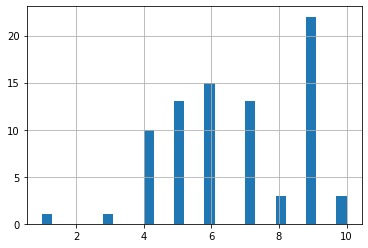

In [ ]:
score = {"grocery": grocscorelist,
        "coffee": cofscorelist,
         "fastfood": ffscorelist,
         "park": parkscorelist,
         "gas": gasscoreslist,
         "theater": theaterscorelist,
         "wholefoods": wfscorelist,
         "traditional": traditionalscores
}
realestate = pd.DataFrame(score, columns = ["grocery", "coffee", "fastfood","park", "gas", "theater", "wholefoods", "traditional"])
#realestate['grocery'].hist(bins = 30, range=[1, 10])
#realestate['coffee'].hist(range=[1, 10])
realestate['fastfood'].hist(bins = 30, range=[1, 10])
#realestate['park'].hist(bins = 30, range=[1, 10])
#realestate['gas'].hist(bins = 30, range=[1, 10])
#realestate['theater'].hist(bins = 30, range=[1, 10])
#realestate['wholefoods'].hist(range=[1, 10])
#realestate['traditional'].hist(bins = 30, range=[1, 10])


In [ ]:
import random
high = 0

for a in range(5000):
  dist1 = random.uniform(0,1)
  dist2 = random.uniform(dist1 + .3,2)
  dist3 = random.uniform(dist2 + .3,3)
  dist4 = random.uniform(dist3 + .3,4)
  dist5 = random.uniform(dist4 + .3 ,5)
  score = 0
  groc = []
  for i in range(num_houses):
    groc.append([0])
    for j in range(num_categories):
      num_stores = len(categories_latlist[j])
      dist_to_stores = [LatLongDist(float(house_latlist.iloc[i]), float(house_longlist.iloc[i]), float(categories_latlist[j].iloc[a]), float(categories_longlist[j].iloc[a])) for a in range(num_stores)]
      if j == 0: #groc
        groc[i][0] = score_from_distances(dist_to_stores, dist1, dist2, dist3,dist4,dist5)
  X = groc
  Y = []

  for target in house_df2['monthly change']:
    Y.append(target)
  for b in range(5000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
  
    pred_list = []
    for score_list in x_test:
      pred_list.append(predict(score_list, regr.intercept_, regr.coef_))
    score += get_accuracy(1, y_test, pred_list)
  score = score/5000
  if high < score:
    print(score)
    print("groc", " ", dist1, " ", dist2, " ", dist3, " ", dist4, " ",  dist5, " " )  
    high = score
 

95.14095238095642
groc   0.8537614267174861   1.2357199963542054   1.747100159754727   3.811272206267158   4.93808629764138  
95.6666666666706
groc   0.18581626629233972   1.0921621737185168   2.934499071623928   3.852627436728964   4.588718735738951  
95.76000000000401
groc   0.9914728496388197   1.487950557978935   2.6396895448744297   3.2580033918110747   3.635046489580718  
95.80285714286143
groc   0.00031095177535744867   1.9710879632929927   2.6540413005413113   3.3605272403282043   4.955066422469966  
95.85047619048014
groc   0.027617475947883885   1.7471630018786526   2.7330085288736177   3.2741862050721067   4.5523243616080125  
95.95238095238513
groc   0.2689534056543491   1.8436480532852781   2.9866542066047685   3.9971935885561276   4.35490358703913  
96.00666666667058
groc   0.1693347835732404   1.7029393411536033   2.889615638991712   3.772310903501843   4.546405255866697  
96.21428571428964
groc   0.1890374638807426   1.5376268601818652   2.3739507829795166   3.764669574

In [ ]:
import random
high = 0

for a in range(5000):
  dist1 = random.uniform(0,1)
  dist2 = random.uniform(dist1 + .3,2)
  dist3 = random.uniform(dist2 + .3,3)
  dist4 = random.uniform(dist3 + .3,4)
  dist5 = random.uniform(dist4 + .3 ,5)
  score = 0
  cof = []
  for i in range(num_houses):
    cof.append([0])
    for j in range(num_categories):
      num_stores = len(categories_latlist[j])
      dist_to_stores = [LatLongDist(float(house_latlist.iloc[i]), float(house_longlist.iloc[i]), float(categories_latlist[j].iloc[a]), float(categories_longlist[j].iloc[a])) for a in range(num_stores)]
      if j == 1: #wholefoods
        cof[i][0] = score_from_distances(dist_to_stores, dist1, dist2, dist3,dist4,dist5)
  X = cof
  Y = []

  for target in house_df2['monthly change']:
    Y.append(target)
  for b in range(5000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
  
    pred_list = []
    for score_list in x_test:
      pred_list.append(predict(score_list, regr.intercept_, regr.coef_))
    score += get_accuracy(1, y_test, pred_list)
  score = score/5000
  if high < score:
    print(score)
    print("coffee", " ", dist1, " ", dist2, " ", dist3, " ", dist4, " ",  dist5, " " )  
    high = score
 

57.32941176470787
coffee   0.13506961042605348   1.7751558495781472   2.257662026887801   2.969525941490635   3.620790789342964  
58.063529411766815
coffee   0.49318566789114127   1.8474658896928522   2.2575134366203486   2.6121937821896686   4.21573256611033  
58.35058823529601
coffee   0.19276783298974554   1.9842938758810187   2.464227464342586   3.4588801425310725   3.93648382758907  


In [ ]:
import random
high = 0

for a in range(5000):
  dist1 = random.uniform(0,1)
  dist2 = random.uniform(dist1 + .3,2)
  dist3 = random.uniform(dist2 + .3,3)
  dist4 = random.uniform(dist3 + .3,4)
  dist5 = random.uniform(dist4 + .3 ,5)
  score = 0
  fast = []
  for i in range(num_houses):
    fast.append([0])
    for j in range(num_categories):
      num_stores = len(categories_latlist[j])
      dist_to_stores = [LatLongDist(float(house_latlist.iloc[i]), float(house_longlist.iloc[i]), float(categories_latlist[j].iloc[a]), float(categories_longlist[j].iloc[a])) for a in range(num_stores)]
      if j == 2: #wholefoods
        fast[i][0] = score_from_inferiors(dist_to_stores, dist1, dist2, dist3,dist4,dist5)
  X = fast
  Y = []

  for target in house_df2['monthly change']:
    Y.append(target)
  for b in range(5000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
  
    pred_list = []
    for score_list in x_test:
      pred_list.append(predict(score_list, regr.intercept_, regr.coef_))
    score += get_accuracy(1, y_test, pred_list)
  score = score/5000
  if high < score:
    print(score)
    print("fast", " ", dist1, " ", dist2, " ", dist3, " ", dist4, " ",  dist5, " " )  
    high = score
 

In [ ]:
import random
high = 0

for a in range(5000):
  dist1 = random.uniform(0,1)
  dist2 = random.uniform(dist1 + .3,2)
  dist3 = random.uniform(dist2 + .3,3)
  dist4 = random.uniform(dist3 + .3,4)
  dist5 = random.uniform(dist4 + .3 ,5)
  score = 0
  park = []
  for i in range(num_houses):
    park.append([0])
    for j in range(num_categories):
      num_stores = len(categories_latlist[j])
      dist_to_stores = [LatLongDist(float(house_latlist.iloc[i]), float(house_longlist.iloc[i]), float(categories_latlist[j].iloc[a]), float(categories_longlist[j].iloc[a])) for a in range(num_stores)]
      if j == 3: #wholefoods
        park[i][0] = score_from_distances(dist_to_stores, dist1, dist2, dist3,dist4,dist5)
  X = park
  Y = []

  for target in house_df2['monthly change']:
    Y.append(target)
  for b in range(5000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
  
    pred_list = []
    for score_list in x_test:
      pred_list.append(predict(score_list, regr.intercept_, regr.coef_))
    score += get_accuracy(1, y_test, pred_list)
  score = score/5000
  if high < score:
    print(score)
    print("parks", " ", dist1, " ", dist2, " ", dist3, " ", dist4, " ",  dist5, " " )  
    high = score
 

In [ ]:
import random
high = 0

for a in range(5000):
  dist1 = random.uniform(0,1)
  dist2 = random.uniform(dist1 + .3,2)
  dist3 = random.uniform(dist2 + .3,3)
  dist4 = random.uniform(dist3 + .3,4)
  dist5 = random.uniform(dist4 + .3 ,5)
  score = 0
  gas = []
  for i in range(num_houses):
    gas.append([0])
    for j in range(num_categories):
      num_stores = len(categories_latlist[j])
      dist_to_stores = [LatLongDist(float(house_latlist.iloc[i]), float(house_longlist.iloc[i]), float(categories_latlist[j].iloc[a]), float(categories_longlist[j].iloc[a])) for a in range(num_stores)]
      if j == 4: #wholefoods
        gas[i][0] = score_from_distances(dist_to_stores, dist1, dist2, dist3,dist4,dist5)
  X = gas
  Y = []

  for target in house_df2['monthly change']:
    Y.append(target)
  for b in range(5000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
  
    pred_list = []
    for score_list in x_test:
      pred_list.append(predict(score_list, regr.intercept_, regr.coef_))
    score += get_accuracy(1, y_test, pred_list)
  score = score/5000
  if high < score:
    print(score)
    print("gas", " ", dist1, " ", dist2, " ", dist3, " ", dist4, " ",  dist5, " " )  
    high = score
 

In [ ]:
import random
high = 0

for a in range(5000):
  dist1 = random.uniform(0,1)
  dist2 = random.uniform(dist1 + .3,2)
  dist3 = random.uniform(dist2 + .3,3)
  dist4 = random.uniform(dist3 + .3,4)
  dist5 = random.uniform(dist4 + .3 ,5)
  score = 0
  thea = []
  for i in range(num_houses):
    thea.append([0])
    for j in range(num_categories):
      num_stores = len(categories_latlist[j])
      dist_to_stores = [LatLongDist(float(house_latlist.iloc[i]), float(house_longlist.iloc[i]), float(categories_latlist[j].iloc[a]), float(categories_longlist[j].iloc[a])) for a in range(num_stores)]
      if j == 5: #wholefoods
        thea[i][0] = score_from_distances(dist_to_stores, dist1, dist2, dist3,dist4,dist5)
  X = thea
  Y = []

  for target in house_df2['monthly change']:
    Y.append(target)
  for b in range(5000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
  
    pred_list = []
    for score_list in x_test:
      pred_list.append(predict(score_list, regr.intercept_, regr.coef_))
    score += get_accuracy(1, y_test, pred_list)
  score = score/5000
  if high < score:
    print(score)
    print("theater", " ", dist1, " ", dist2, " ", dist3, " ", dist4, " ",  dist5, " " )  
    high = score
 

In [ ]:
import random
high = 0

for a in range(5000):
  dist1 = random.uniform(0,1)
  dist2 = random.uniform(dist1 + .3,2)
  dist3 = random.uniform(dist2 + .3,3)
  dist4 = random.uniform(dist3 + .3,4)
  dist5 = random.uniform(dist4 + .3 ,5)
  score = 0
  wholescore = []
  for i in range(num_houses):
    wholescore.append([0])
    for j in range(num_categories):
      num_stores = len(categories_latlist[j])
      dist_to_stores = [LatLongDist(float(house_latlist.iloc[i]), float(house_longlist.iloc[i]), float(categories_latlist[j].iloc[a]), float(categories_longlist[j].iloc[a])) for a in range(num_stores)]
      if j == 6: #wholefoods
        wholescore[i][0] = score_from_distances(dist_to_stores, dist1, dist2, dist3,dist4,dist5)
  X = wholescore
  Y = []

  for target in house_df2['monthly change']:
    Y.append(target)
  for b in range(5000):
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25)

    regr = linear_model.LinearRegression()
    regr.fit(x_train, y_train)
  
    pred_list = []
    for score_list in x_test:
      pred_list.append(predict(score_list, regr.intercept_, regr.coef_))
    score += get_accuracy(1, y_test, pred_list)
  score = score/5000
  if high < score:
    print(score)
    print("wholefoods", " ", dist1, " ", dist2, " ", dist3, " ", dist4, " ",  dist5, " " )  
    high = score
 
 